In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import sqlite3
import json
from datetime import datetime

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [4]:
from scipy.stats import spearmanr

## read in data from local sqlite database
read in data 

In [5]:
df = pd.read_json('../ML_data_JJA.json')

## clean data

In [6]:
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['新竹浮標','臺東外洋浮標','東沙島浮標','馬祖浮標']
stnlist=['臺東外洋浮標','東沙島浮標','馬祖浮標']

dataset = dataset[dataset['STN'].isin(stnlist)]
dataset = dataset.dropna()

<Figure size 3200x1600 with 0 Axes>

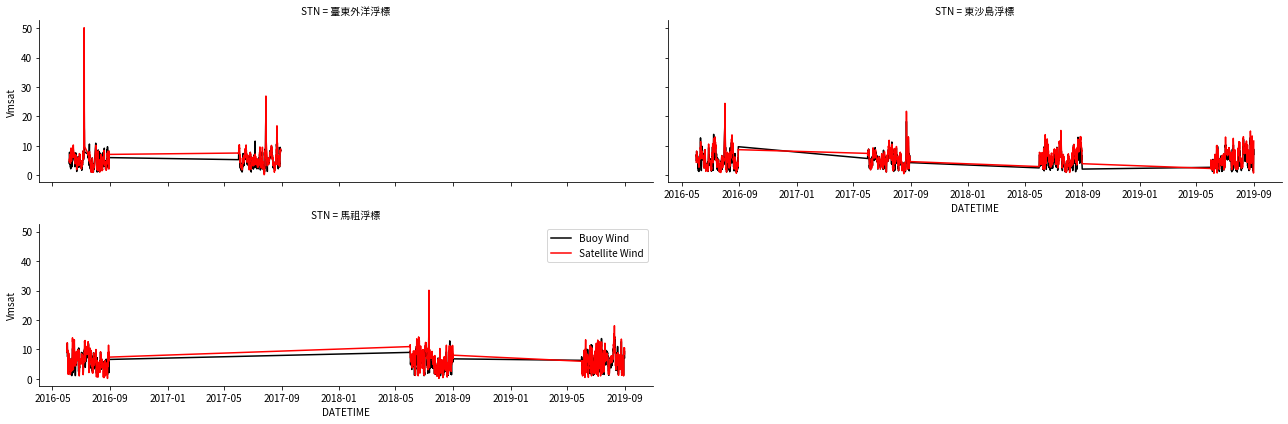

In [7]:
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

In [8]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

151030    臺東外洋浮標
151036    臺東外洋浮標
151042    臺東外洋浮標
151048    臺東外洋浮標
151054    臺東外洋浮標
           ...  
874189      馬祖浮標
874195      馬祖浮標
874201      馬祖浮標
874207      馬祖浮標
874213      馬祖浮標
Name: STN, Length: 2993, dtype: object

In [9]:
dataset.isna().sum()

H        0
Temp     0
P        0
Vm       0
Vmsat    0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [10]:
dataset = dataset.dropna()
dataset.isna().sum()

H        0
Temp     0
P        0
Vm       0
Vmsat    0
dtype: int64

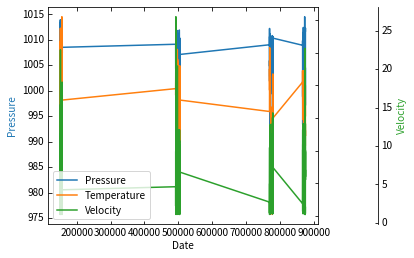

In [11]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right", axes=par2,
                                        offset=(offset, 0))

par2.axis["right"].toggle(all=True)


host.set_xlabel("Date")
host.set_ylabel("Pressure")
par1.set_ylabel("Temperature")
par2.set_ylabel("Velocity")

p1, = host.plot(dataset['P'], label="Pressure")
p2, = par1.plot(dataset['Temp'], label="Temperature")
p3, = par2.plot(dataset['Vm'], label="Velocity")

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())

host.legend()

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

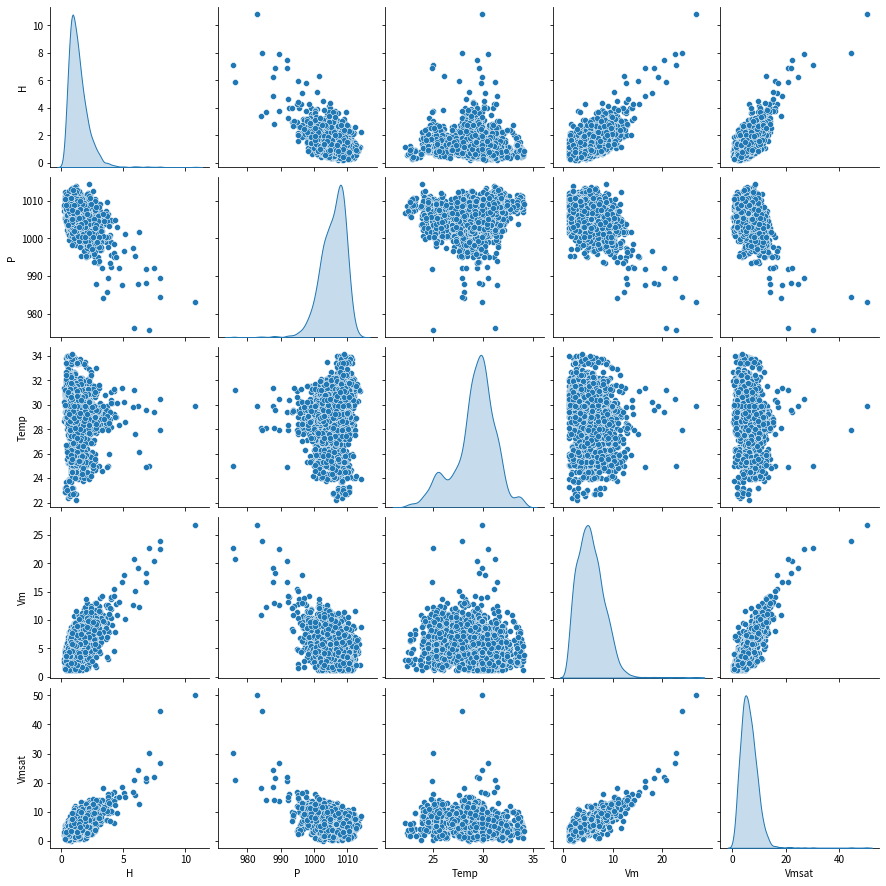

In [13]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [14]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
H,2394.0,1.400789,0.828046,0.230000,0.85000,1.225000,1.740000,10.830000
Temp,2394.0,29.153926,2.052508,22.200000,28.30000,29.500000,30.400000,34.100000
P,2394.0,1005.697536,3.849774,975.700000,1003.40000,1006.300000,1008.500000,1014.300000
Vm,2394.0,5.594194,2.733343,1.100000,3.60000,5.300000,7.200000,26.800000
Vmsat,2394.0,6.171065,3.194736,0.168848,4.05566,5.807255,7.870123,50.117094


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [15]:
train_features_s1 = train_dataset.copy()
test_features_s1 = test_dataset.copy()
train_labels_s1 = train_features_s1.pop('Vm')
test_labels_s1 = test_features_s1.pop('Vm')

train_features_s2 = train_dataset.copy()
test_features_s2 = test_dataset.copy()
train_labels_s2 = train_features_s2.pop('H')
test_labels_s2 = test_features_s2.pop('H')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [16]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
H,1.400789,0.828046
Temp,29.153926,2.052508
P,1005.697536,3.849774
Vm,5.594194,2.733343
Vmsat,6.171065,3.194736


## Two Steps AI

### One Variable



In [17]:
linear_model = tf.keras.models.load_model('saved_model/Vmsat_H_Vm_model_JJA')
dnn_model    = tf.keras.models.load_model('saved_model/Vmsat_H_dnn_Vm_model_JJA')
dnn_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_dnn_Vmsat_model_JJA')
dnn_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_dnn_Vm_model_JJA')
rnn_model    = tf.keras.models.load_model('saved_model/Vmsat_H_rnn_Vm_model_JJA')
rnn_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_rnn_Vmsat_model_JJA')
rnn_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_rnn_Vm_model_JJA')
import joblib
svr_model    = joblib.load("saved_model/Vmsat_H_svr_Vm_model_JJA")
svr_model_s1 = joblib.load("saved_model/Vmsat_Vm_svr_Vm_model_JJA")
svr_model_s2 = joblib.load("saved_model/Vm_H_svr_Vm_model_JJA")

# Check its architecture
linear_model.summary()
dnn_model.summary()
dnn_model_s1.summary()
dnn_model_s2.summary()
rnn_model.summary()
rnn_model_s1.summary()
rnn_model_s2.summary()

#ddn_model_s1.predict(test_features)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
________________________________________

In [18]:
test_labels_s1, test_labels_s2

(151030    5.3
 151048    8.2
 151072    7.9
 151168    1.6
 151186    3.8
          ... 
 874082    6.0
 874100    1.6
 874147    8.0
 874183    8.6
 874213    6.8
 Name: Vm, Length: 599, dtype: float64,
 151030    1.60
 151048    2.41
 151072    2.67
 151168    0.70
 151186    0.90
           ... 
 874082    2.04
 874100    1.84
 874147    2.06
 874183    1.99
 874213    0.92
 Name: H, Length: 599, dtype: float64)

In [19]:
wave_height = dnn_model_s2.predict(dnn_model_s1.predict(test_features_s1['Vmsat']))

Collect the results on the test set, for later:

In [20]:
def svr_evaluate(test_features, test_labels):
    return np.mean(np.abs(np.array(test_features)-np.array(test_labels)))

test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features_s2['Vmsat'],
    test_labels_s2, verbose=0)

test_results['dnn_model_1step'] = dnn_model.evaluate(
    test_features_s2['Vmsat'],
    test_labels_s2, verbose=0)

test_results['dnn_model_2step'] = dnn_model_s2.evaluate(
    dnn_model_s1.predict(test_features_s1['Vmsat']),
    test_labels_s2, verbose=0)

test_results['rnn_model_1step'] = rnn_model.evaluate(
    test_features_s2['Vmsat'],
    test_labels_s2, verbose=0)

test_results['rnn_model_2step'] = rnn_model_s2.evaluate(
    rnn_model_s1.predict(test_features_s1['Vmsat']),
    test_labels_s2, verbose=0)

test_results['svr_model_1step'] = svr_evaluate(
    svr_model.predict(np.array(test_features_s2['Vmsat']).reshape(-1,1)),
    test_labels_s2)

test_results['svr_model_2step'] = svr_evaluate(
    svr_model_s2.predict(np.array(svr_model_s1.predict(np.array(test_features_s1['Vmsat']).reshape(-1,1))).reshape(-1,1)),
    test_labels_s2)


In [21]:
def plot_Vmsat(x, y):
  plt.scatter(train_features_s2['Vmsat'],train_labels_s2, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vmsat')
  plt.ylabel('H')
  plt.legend()

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [22]:
x = np.linspace(0,40,100)
#y = Vmsat_model.predict(x)
y =  dnn_model_s2.predict(dnn_model_s1.predict(pd.DataFrame(x)))


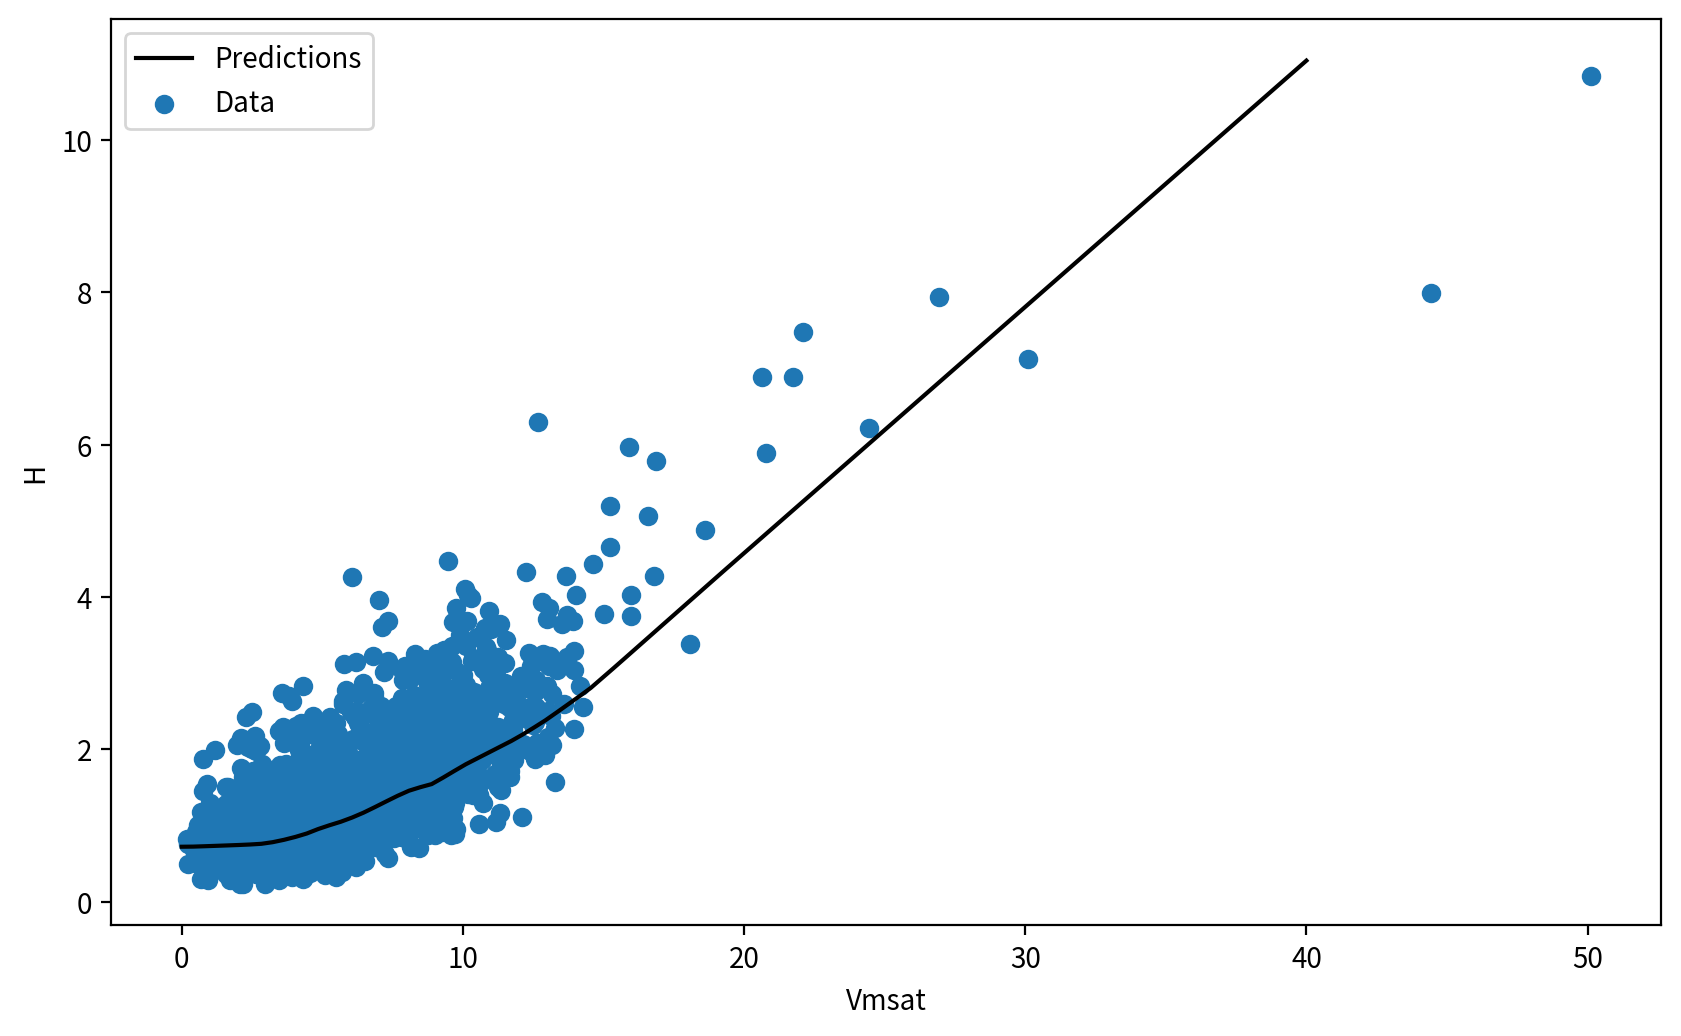

In [23]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vmsat(x,y)

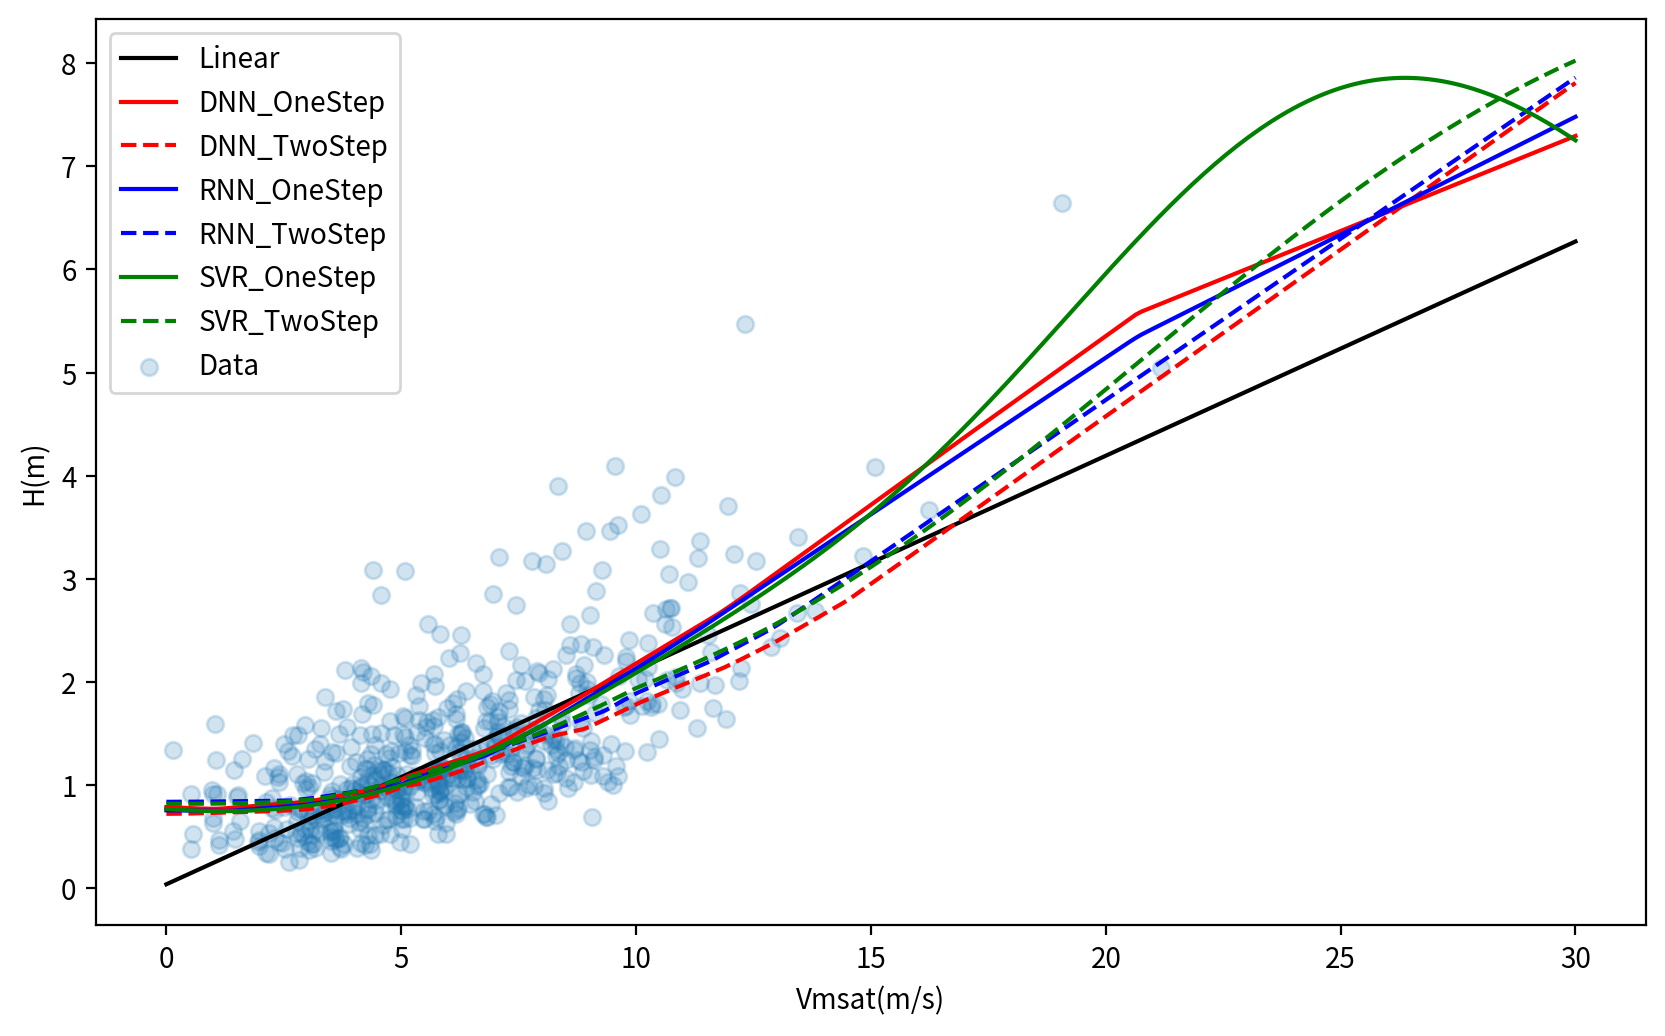

In [24]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 30, 251)
y  = linear_model.predict(pd.DataFrame(x))
y1 = dnn_model.predict(pd.DataFrame(x))
y2 = dnn_model_s2.predict(dnn_model_s1.predict(pd.DataFrame(x)))
y3 = rnn_model.predict(pd.DataFrame(x))
y4 = rnn_model_s2.predict(rnn_model_s1.predict(pd.DataFrame(x)))
y5 = svr_model.predict(pd.DataFrame(x))
y6 = svr_model_s2.predict(rnn_model_s1.predict(pd.DataFrame(x)))

plt.scatter(test_features_s2['Vmsat'], test_labels_s2, label='Data',alpha=0.2)
plt.plot(x, y , color='k', label='Linear')
plt.plot(x, y1, color='r', label='DNN_OneStep')
plt.plot(x, y2, color='r', linestyle='--', label='DNN_TwoStep')
plt.plot(x, y3, color='b', label='RNN_OneStep')
plt.plot(x, y4, color='b', linestyle='--', label='RNN_TwoStep')
plt.plot(x, y5, color='g', label='SVR_OneStep')
plt.plot(x, y6, color='g', linestyle='--', label='SVR_TwoStep')

plt.xlabel('Vmsat(m/s)')
plt.ylabel('H(m)')
plt.legend()

In [25]:
df = pd.DataFrame(test_results, index=['Mean absolute error of H [m] ']).T
#df['Total absolute error of H[m]'] = df['Mean absolute error of H [m] ']*len(test_labels_s2)
df['Total # of test cases'] = len(test_labels_s2)
df['Total # of train cases'] = len(train_labels_s2)
df['Total error reduction[%]'] = ((df['Mean absolute error of H [m] '][0]-df['Mean absolute error of H [m] '])/df['Mean absolute error of H [m] '][0])*100
df

,Mean absolute error of H [m],Total # of test cases,Total # of train cases,Total error reduction[%]
linear_model,0.406061,599,2394,0.000000
dnn_model_1step,0.392425,599,2394,3.358188
dnn_model_2step,0.384856,599,2394,5.221999
rnn_model_1step,0.385648,599,2394,5.027154
rnn_model_2step,0.384257,599,2394,5.369558
svr_model_1step,0.384794,599,2394,5.237336
svr_model_2step,0.384706,599,2394,5.259068


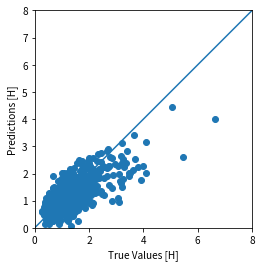

In [26]:
test_predictions = linear_model.predict(test_features_s2['Vmsat']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

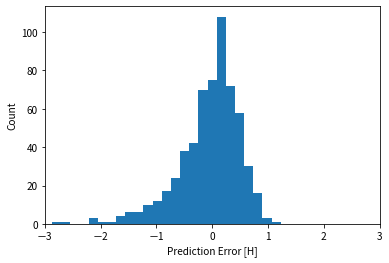

In [27]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

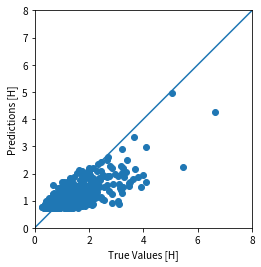

In [28]:
test_predictions = dnn_model_s2.predict(dnn_model_s1.predict(test_features_s1['Vmsat'])).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

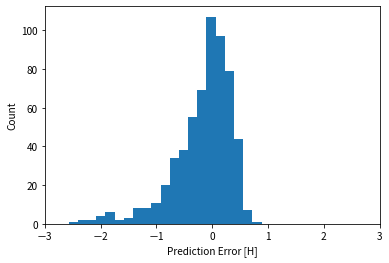

In [29]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

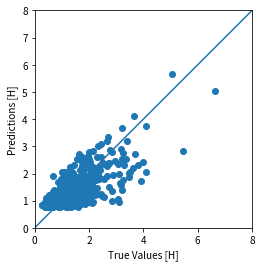

In [30]:
test_predictions = dnn_model.predict(test_features_s2['Vmsat']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

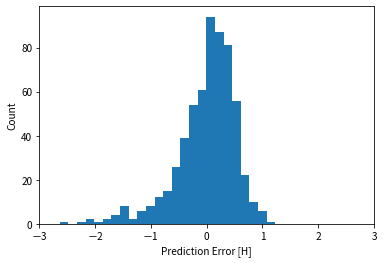

In [31]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

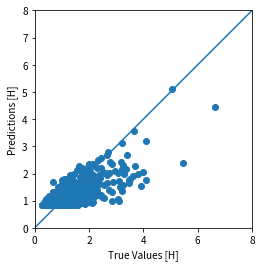

In [32]:
test_predictions = rnn_model_s2.predict(rnn_model_s1.predict(test_features_s1['Vmsat'])).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

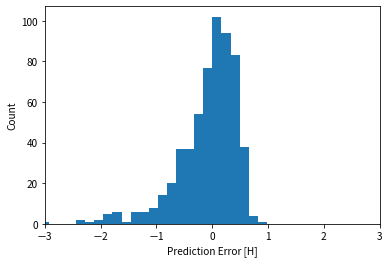

In [33]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

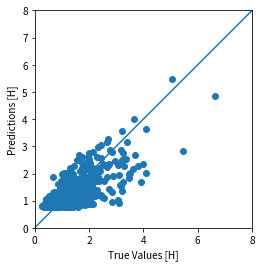

In [34]:
test_predictions = rnn_model.predict(test_features_s2['Vmsat']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

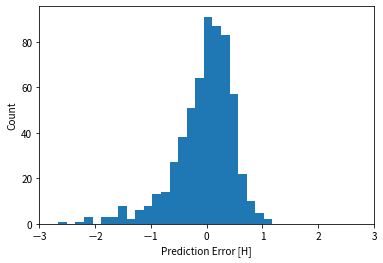

In [35]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

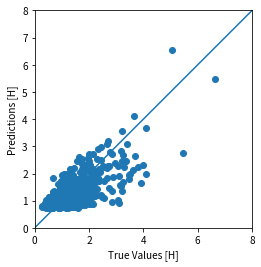

In [36]:
test_predictions = svr_model.predict(np.array(test_features_s2['Vmsat']).reshape(-1,1)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

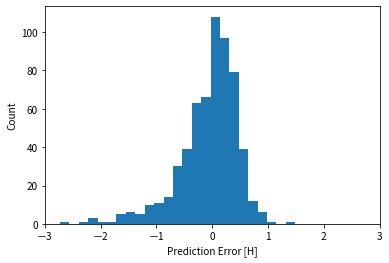

In [37]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

### Multiple inputs

In [38]:
linear_model = tf.keras.models.load_model('saved_model/Vmsat_H_linear_model_JJA')
dnn_model    = tf.keras.models.load_model('saved_model/Vmsat_H_dnn_model_JJA')
dnn_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_dnn_model_JJA')
dnn_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_dnn_Vm_model_JJA')
rnn_model    = tf.keras.models.load_model('saved_model/Vmsat_H_rnn_model_JJA')
rnn_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_rnn_model_JJA')
rnn_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_rnn_Vm_model_JJA')
import joblib
svr_model    = joblib.load("saved_model/Vmsat_H_svr_model_JJA")
svr_model_s1 = joblib.load("saved_model/Vmsat_Vm_svr_model_JJA")
svr_model_s2 = joblib.load("saved_model/Vm_H_svr_Vm_model_JJA")

# Check its architecture
linear_model.summary()
dnn_model.summary()
dnn_model_s1.summary()
dnn_model_s2.summary()
rnn_model.summary()
rnn_model_s1.summary()
rnn_model_s2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_____________________________________

In [39]:
def svr_evaluate(test_features, test_labels):
    return np.mean(np.abs(np.array(test_features)-np.array(test_labels)))

test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features_s2,
    test_labels_s2, verbose=0)

test_results['dnn_model_1step'] = dnn_model.evaluate(
    test_features_s2,
    test_labels_s2, verbose=0)

test_results['dnn_model_2step'] = dnn_model_s2.evaluate(
    dnn_model_s1.predict(test_features_s1),
    test_labels_s2, verbose=0)

test_results['rnn_model_1step'] = rnn_model.evaluate(
    test_features_s2,
    test_labels_s2, verbose=0)

test_results['rnn_model_2step'] = rnn_model_s2.evaluate(
    rnn_model_s1.predict(test_features_s1),
    test_labels_s2, verbose=0)

test_results['svr_model_1step'] = svr_evaluate(
    svr_model.predict(test_features_s2),
    test_labels_s2)

test_results['svr_model_2step'] = svr_evaluate(
    svr_model_s2.predict(np.array(svr_model_s1.predict(test_features_s1)).reshape(-1,1)),
    test_labels_s2)

In [40]:
df = pd.DataFrame(test_results, index=['Mean absolute error of H [m] ']).T
#df['Total absolute error of H [m]'] = df['Mean absolute error of H [m] ']*len(test_labels_s1)
df['Total # of test cases'] = len(test_labels_s1)
df['Total # of train cases'] = len(train_labels_s1)
df['Total error reduction[%]'] = ((df['Mean absolute error of H [m] '][0]-df['Mean absolute error of H [m] '])/df['Mean absolute error of H [m] '][0])*100
df

,Mean absolute error of H [m],Total # of test cases,Total # of train cases,Total error reduction[%]
linear_model,0.368238,599,2394,0.000000
dnn_model_1step,0.316267,599,2394,14.113251
dnn_model_2step,0.382735,599,2394,-3.936855
rnn_model_1step,0.537104,599,2394,-45.857969
rnn_model_2step,0.541300,599,2394,-46.997367
svr_model_1step,0.320004,599,2394,13.098548
svr_model_2step,0.385243,599,2394,-4.618035


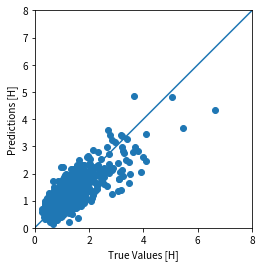

In [41]:
test_predictions = linear_model.predict(test_features_s2).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

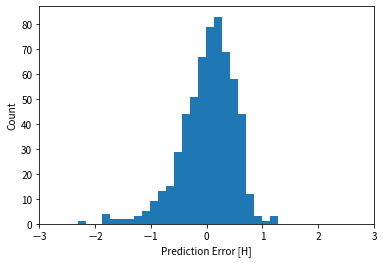

In [42]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

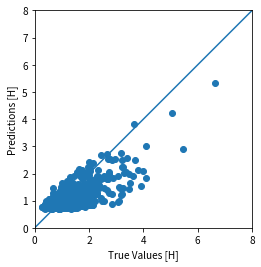

In [43]:
test_predictions = dnn_model_s2.predict(dnn_model_s1.predict(test_features_s1)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

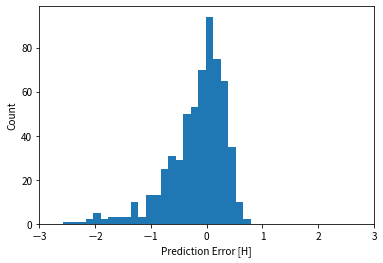

In [44]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

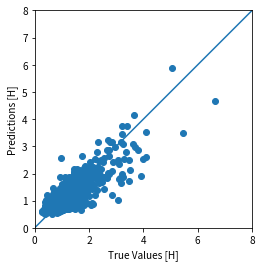

In [45]:
test_predictions = dnn_model.predict(test_features_s2).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels_s2, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

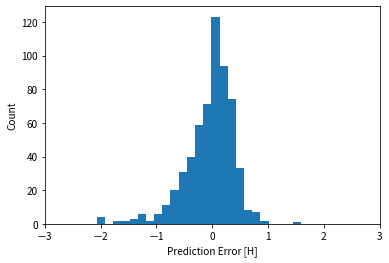

In [46]:
error = test_predictions - test_labels_s2
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
plt.xlim([-3,3])
_ = plt.ylabel('Count')

In [47]:
linear_model = tf.keras.models.load_model('saved_model/Vmsat_H_linear_model_JJA')
linear_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_linear_model_JJA')
linear_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_dnn_Vm_model_JJA')
dnn_model    = tf.keras.models.load_model('saved_model/Vmsat_H_dnn_model_JJA')
dnn_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_dnn_model_JJA')
dnn_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_dnn_Vm_model_JJA')


# Check its architecture
linear_model.summary()
dnn_model.summary()
dnn_model_s1.summary()
dnn_model_s2.summary()

test_results = {}

test_results['linear_model_1step'] = linear_model.evaluate(
    test_features_s2,
    test_labels_s2, verbose=0)

test_results['linear_model_2step'] = linear_model_s2.evaluate(
    linear_model_s1.predict(test_features_s1),
    test_labels_s2, verbose=0)

test_results['dnn_model_1step'] = dnn_model.evaluate(
    test_features_s2,
    test_labels_s2, verbose=0)

test_results['dnn_model_2step'] = dnn_model_s2.evaluate(
    dnn_model_s1.predict(test_features_s1),
    test_labels_s2, verbose=0)



df = pd.DataFrame(test_results, index=['Mean absolute error of H [m] ']).T
#df['Total absolute error of H [m]'] = df['Mean absolute error of H [m] ']*len(test_labels_s1)
df['Total # of test cases'] = len(test_labels_s1)
df['Total # of train cases'] = len(train_labels_s1)
df['Total error reduction[%]'] = ((df['Mean absolute error of H [m] '][0]-df['Mean absolute error of H [m] '])/df['Mean absolute error of H [m] '][0])*100
df

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_____________________________________

,Mean absolute error of H [m],Total # of test cases,Total # of train cases,Total error reduction[%]
linear_model_1step,0.368238,599,2394,0.000000
linear_model_2step,0.398716,599,2394,-8.276761
dnn_model_1step,0.316267,599,2394,14.113251
dnn_model_2step,0.382735,599,2394,-3.936855


In [48]:
linear_model = tf.keras.models.load_model('saved_model/Vmsat_H_Vm_model_JJA')
linear_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_Vmsat_model_JJA')
linear_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_dnn_Vm_model_JJA')
dnn_model    = tf.keras.models.load_model('saved_model/Vmsat_H_dnn_Vm_model_JJA')
dnn_model_s1 = tf.keras.models.load_model('saved_model/Vmsat_Vm_dnn_Vmsat_model_JJA')
dnn_model_s2 = tf.keras.models.load_model('saved_model/Vm_H_dnn_Vm_model_JJA')


# Check its architecture
linear_model.summary()
dnn_model.summary()
dnn_model_s1.summary()
dnn_model_s2.summary()

#ddn_model_s1.predict(test_features)
test_results = {}

test_results['linear_model_1step'] = linear_model.evaluate(
    test_features_s2['Vmsat'],
    test_labels_s2, verbose=0)

test_results['linear_model_2step'] = linear_model_s2.evaluate(
    linear_model_s1.predict(test_features_s1['Vmsat']),
    test_labels_s2, verbose=0)

test_results['dnn_model_1step'] = dnn_model.evaluate(
    test_features_s2['Vmsat'],
    test_labels_s2, verbose=0)

test_results['dnn_model_2step'] = dnn_model_s2.evaluate(
    dnn_model_s1.predict(test_features_s1['Vmsat']),
    test_labels_s2, verbose=0)


df = pd.DataFrame(test_results, index=['Mean absolute error of H [m] ']).T
#df['Total absolute error of H[m]'] = df['Mean absolute error of H [m] ']*len(test_labels_s2)
df['Total # of test cases'] = len(test_labels_s2)
df['Total # of train cases'] = len(train_labels_s2)
df['Total error reduction[%]'] = ((df['Mean absolute error of H [m] '][0]-df['Mean absolute error of H [m] '])/df['Mean absolute error of H [m] '][0])*100
df

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
________________________________________

,Mean absolute error of H [m],Total # of test cases,Total # of train cases,Total error reduction[%]
linear_model_1step,0.406061,599,2394,0.000000
linear_model_2step,0.381279,599,2394,6.103098
dnn_model_1step,0.392425,599,2394,3.358188
dnn_model_2step,0.384856,599,2394,5.221999
